In [170]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
#from algorithm import C_min, C_max, lower, upper
from trash_data import TRASH_AVG, TRASH_STD
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

%matplotlib widget

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_31603/2228338476.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [171]:
SQRT_2 = np.sqrt(2)
SQRT_2_OVER_PI = np.sqrt(2/np.pi)

W_p = TRASH_AVG*7*10**3
SIGMA_p = TRASH_STD*7*10**3
SIGMA_c = np.array([0.8]*12)*10**3
P = np.array([78380,92445,163141,131351,63600,155614,222129,231983,110458,130440,125771,180206])/10**3
A = np.array([40710976, 37719022, 46882269, 49291774, 43796730, 38695300, 53154204, 55045848, 41892850, 39080798, 66146445, 77969957])/10.764/10**6
N_total = 1000
Z_min = 0.00001
Z_max = 5
Q_bound = 4
R = 12*10**3
MAX_ITERATION = 5000


In [172]:
#Calculate lower bound for each district
lower = np.ceil((2*R*W_p+Z_min**2*SIGMA_c**2+((2*R*W_p+Z_min**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_min**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

#Calculate upper bound for each district
upper = np.floor((2*R*W_p+Z_max**2*SIGMA_c**2+((2*R*W_p+Z_max**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_max**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

#bounds for C
C_min = np.sum(lower)
C_max = np.sum(upper)

def Q(T):
    mu = W_p-R*T
    sigma = np.sqrt(SIGMA_p**2+SIGMA_c**2*T)
    delta = 1/2*(mu*erf(mu/(SQRT_2*sigma))+mu+SQRT_2_OVER_PI*sigma*np.exp(-mu**2/(2*sigma**2)))
    S = np.average(delta/(A*P))
    return np.sqrt(1/12*np.sum((delta/(A*P)-S)**2)), delta

def findMin(T_11,C, iterations):
    # append the 12th index to T_11 to make T
    T = np.append(T_11, C-np.sum(T_11))
    # compute Q
    Q_current, S = Q(T)

    #if the number of iterations is greater than maximum iterations, return
    if iterations > MAX_ITERATION:
        return Q_current
    
    # record minimum Q and the move that minimize Q
    Q_min = Q_current 
    #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
    target_move = [0,0] 
    
    # iterate through all possible moves
    for i in range(11):
        for j in [-1,1]:
            # whether the new condition lie within the upper and lower bounds for each index
            if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                # the new schedule
                T_new = T
                T_new[i]+=j
                T_new[11]-=j
                # compute Q for the new schedule
                Q_new, S = Q(T_new)
                
                # If the new schedule has a lower Q, than record that move
                if Q_new < Q_min:
                    target_move = [i,j]
                    Q_min = Q_new
    
    # if not moving is the best option, then the current Q is minimum               
    if target_move[1] == 0:
        return  Q_current, S, T
    
    
    # do the move
    T_11_new = T_11
    T_11_new[target_move[0]]+=target_move[1]
    
    # iterate
    return findMin(T_11_new, C, iterations+1)
    
    

#Check whether the cost has any possible schedule within the constraint
def min_Q(C):
    #initial position
    T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
    #T_11 = nks[:-1]
    #random initial position
    #T_11 = np.array([np.random.randint(l, u + 1) for l, u in zip(lower[:11], upper[:11])])
    return findMin(T_11,C,0) 

In [16]:
def reset_params():
    #Calculate lower bound for each district
    lower = np.ceil((2*R*W_p+Z_min**2*SIGMA_c**2+((2*R*W_p+Z_min**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_min**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

    #Calculate upper bound for each district
    upper = np.floor((2*R*W_p+Z_max**2*SIGMA_c**2+((2*R*W_p+Z_max**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_max**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

    #bounds for C
    C_min = np.sum(lower)
    C_max = np.sum(upper)

    def Q(T):
        mu = W_p-R*T
        sigma = np.sqrt(SIGMA_p**2+SIGMA_c**2*T)
        delta = 1/2*(mu*erf(mu/(SQRT_2*sigma))+mu+SQRT_2_OVER_PI*sigma*np.exp(-mu**2/(2*sigma**2)))
        S = np.average(delta/(A*P))
        return np.sqrt(1/12*np.sum((delta/(A*P)-S)**2)), delta

    def findMin(T_11,C, iterations):
        # append the 12th index to T_11 to make T
        T = np.append(T_11, C-np.sum(T_11))
        # compute Q
        Q_current, S = Q(T)

        #if the number of iterations is greater than maximum iterations, return
        if iterations > MAX_ITERATION:
            return Q_current
        
        # record minimum Q and the move that minimize Q
        Q_min = Q_current 
        #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
        target_move = [0,0] 
        
        # iterate through all possible moves
        for i in range(11):
            for j in [-1,1]:
                # whether the new condition lie within the upper and lower bounds for each index
                if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                    # the new schedule
                    T_new = T
                    T_new[i]+=j
                    T_new[11]-=j
                    # compute Q for the new schedule
                    Q_new, S = Q(T_new)
                    
                    # If the new schedule has a lower Q, than record that move
                    if Q_new < Q_min:
                        target_move = [i,j]
                        Q_min = Q_new
        
        # if not moving is the best option, then the current Q is minimum               
        if target_move[1] == 0:
            return  Q_current, S, T_11
        
        
        # do the move
        T_11_new = T_11
        T_11_new[target_move[0]]+=target_move[1]
        
        # iterate
        return findMin(T_11_new, C, iterations+1)
        
        

    #Check whether the cost has any possible schedule within the constraint
    def min_Q(C):
        #initial position
        T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
        #random initial position
        #T_11 = np.array([np.random.randint(l, u + 1) for l, u in zip(lower[:11], upper[:11])])
        return findMin(T_11,C,0) 

Text(0.5, 1.0, 'Robustness Efficiency Trade Off')

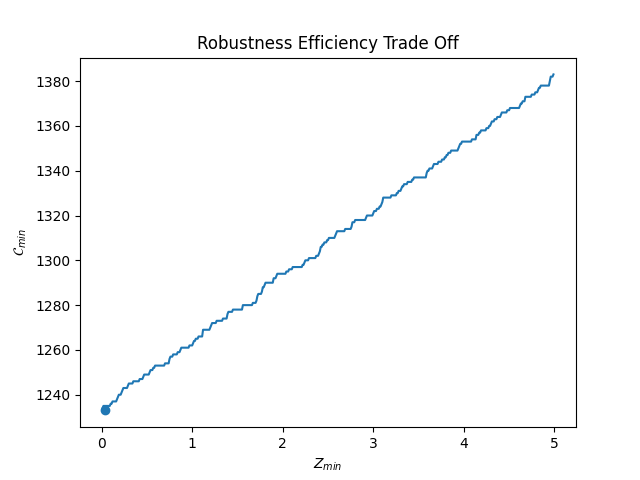

In [137]:
zs = np.arange(0.01,5,0.01)
minCs = []

for z in np.arange(0.01,5,0.01):
    Z_min = z 
    lower = np.ceil((2*R*W_p+Z_min**2*SIGMA_c**2+((2*R*W_p+Z_min**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_min**2*SIGMA_p**2))**(1/2))/(2*R**2))
    minCs.append(np.sum(lower))
plt.figure()
plt.plot(zs, minCs)
plt.ylabel('$\mathcal{C}_{min}$')
plt.xlabel('$Z_{min}$')
plt.scatter(0.04, 1233)

plt.title('Robustness Efficiency Trade Off')



[1. 1.]


/Users/a276me/Library/Python/3.8/lib/python/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


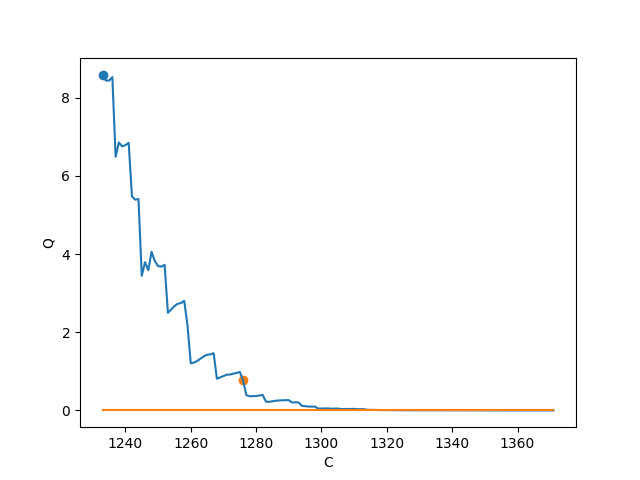

In [53]:
plt.figure()

def fit(x, a, h): return a * 2**(-(x - h))

x = np.array(range(int(C_min),int(C_max)+1))
Qs = []
Ds = []
Ns = []

for i in x:
    #compute minimum Q for each cost
    res = min_Q(i)
    Qs.append(res[0])
    Ds.append(np.array(res[1]))
    Ns.append(res[2])

    
# plot 
plt.plot(x,Qs)   
Ds = np.array(Ds)
Ns = np.array(Ns)
Qs = np.array(Qs)
plt.scatter(1233, 8.59)
plt.scatter(x[43], SQs[43])

guess = (500, x.min())
bounds = [(500,1000), (1000, 3000)]

params, covar = curve_fit(fit, x, Qs)
print(params)
plt.plot(x, fit(x, *params) )
D = 4

# for D in range(len(Ns)):
#     print(Ss[:,D].shape)
#     #print(Ns[:,D].shape)

#     #plt.plot(Ns[:,D] - Ns[:,D].min(), Ss[:,D])

#     plt.plot([i for i in range(len(Ns))], Ns[:,D] - Ns[:,D].min())


# for it in range(len(Ns)):
#     plt.plot(it, )

#plt.plot(x, Qs)
plt.xlabel("C")    # X-axis label
plt.ylabel("Q")    # Y-axis label
plt.show()   

In [173]:
min_Q(1276)

(0.771144319413891,
 array([ 284.16074966,  213.85623544,  652.24251943,  290.92862827,
         859.23939259,  284.02626624, 1207.39996541,  909.05313291,
         354.5750057 ,  873.22497624, 1410.8940027 , 1197.35623639]),
 array([ 60.,  67., 126.,  93.,  49.,  99., 159., 170.,  89., 106., 106.,
        152.]))

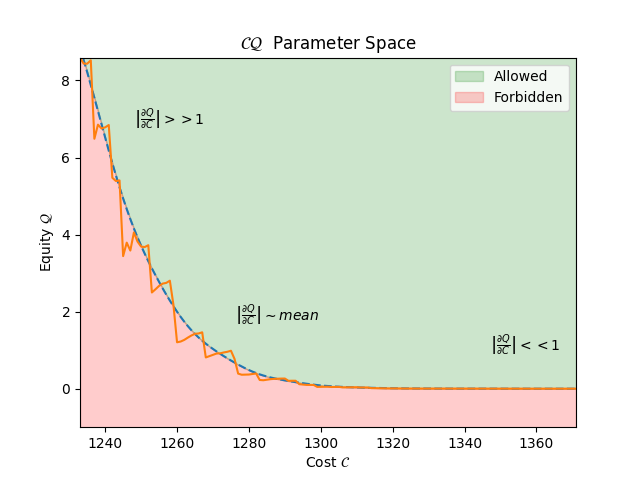

In [109]:
SQs = gaussian_filter(np.array([Qs[0]+2]*40 +Qs.tolist()), 6)[40:]
dqdc = np.diff(Qs) / np.diff(x)


plt.figure()
#plt.plot((x-x.min()), gaussian_filter(Qs, 5))
plt.plot(x, SQs, '--')
plt.plot(x, Qs)

plt.fill_between(x, SQs, SQs.max(), color='green', alpha=0.2, label='Allowed')
plt.fill_between(x, SQs, SQs.min()-1, color='red', alpha=0.2, label='Forbidden')

plt.xlim(x.min(), x.max())
plt.ylim(Qs.min()-1, Qs.max())

#plt.text(x[5], Qs[5], '$\\left|\\frac{\\partial Q}{\\partial C}\\right| >> 1$')

plt.text(x[5]+10, Qs[5], '$\\left|\\frac{\\partial Q}{\\partial C}\\right| >> 1$')
plt.text(x[-5]-20, Qs[-5]+1,'$\\left|\\frac{\\partial Q}{\\partial C}\\right| << 1$')
plt.text(x[43], Qs[43]+1,'$\\left|\\frac{\\partial Q}{\\partial C}\\right| \\sim mean$')


plt.xlabel("Cost $\mathcal{C}$")    # X-axis label
plt.ylabel("Equity $\mathcal{Q}$")    # Y-axis label

plt.title('$\mathcal{C}\mathcal{Q}$  Parameter Space')

plt.legend()

#plt.plot(gaussian_filter(dqdc, 1))

In [153]:
zs[np.argmin(np.abs(f(zs)-1276))]

1.4000000000000001

Text(0.5, 1.0, '$\\mathcal{C} \\mathcal{Q}$ Parameter Space')

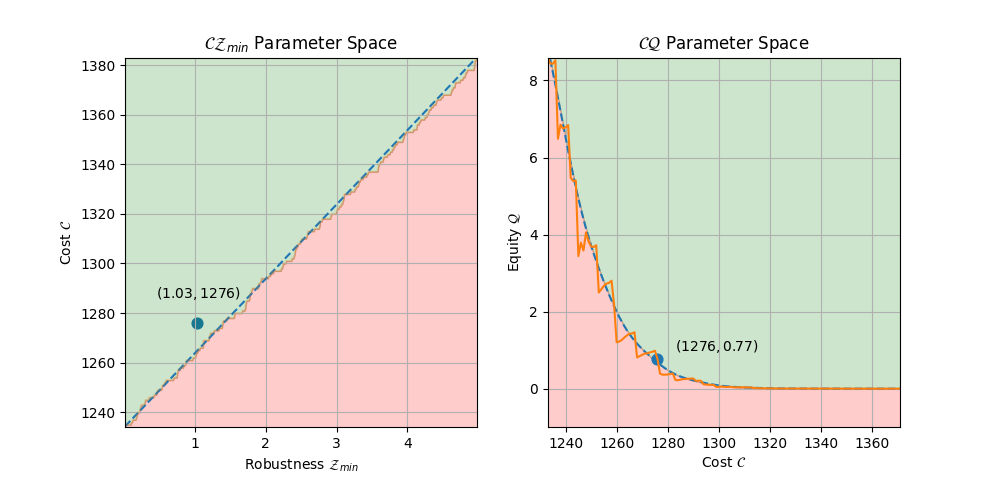

In [212]:
fig, axs = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = axs
fig.set_figwidth(10)

m = (minCs[-1]-minCs[0])/(zs[-1]-zs[0])

def f(z): 
    return m * z + minCs[0]

ax1.plot(zs, f(zs), '--')
ax1.plot(zs, minCs, alpha=0.2)

# ax1.plot([0, 1.03], [1276,1276], 'g--')
# ax1.plot([1.03,1.03], [C_min.min(), 1276], 'g--')

ax1.text(0.45, 1286, '$(1.03, 1276)$')

ax1.scatter(1.03, 1276, s=60, label='Optimized Point')

minCs = np.array(minCs)

ax1.fill_between(zs, minCs, minCs.max(), color='green', alpha=0.2, )
ax1.fill_between(zs, minCs, minCs.min()-1, color='red', alpha=0.2, )

ax1.set_xlim(zs.min(), zs.max())
ax1.set_ylim(minCs.min(), minCs.max())

ax1.set_xlabel("Robustness $\mathcal{Z}_{min}$")    # X-axis label
ax1.set_ylabel("Cost $\mathcal{C}$")    # Y-axis label

ax1.set_title('$\mathcal{C} \mathcal{Z}_{min}$ Parameter Space')
ax1.legend()

ax2.plot(x, SQs, '--')
ax2.plot(x, Qs)

ax2.fill_between(x, SQs, SQs.max(), color='green', alpha=0.2, )
ax2.fill_between(x, SQs, SQs.min()-1, color='red', alpha=0.2, )

ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(Qs.min()-1, Qs.max())

ax2.scatter(x[43], Qs[43], s=60, label='Optimized Point')
ax2.text(x[43]+7,  Qs[43]+0.2, f'$(1276, 0.77)$')

ax2.grid()
ax1.grid()

ax2.legend()

ax2.set_xlabel("Cost $\mathcal{C}$")    # X-axis label
ax2.set_ylabel("Equity $\mathcal{Q}$")    # Y-axis label
ax2.set_title('$\mathcal{C} \mathcal{Q}$ Parameter Space')



<Figure size 640x480 with 0 Axes>

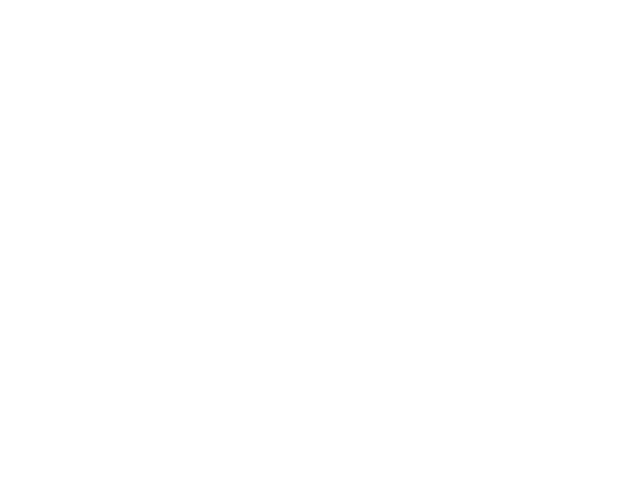

In [97]:
plt.figure()

In [18]:
nks = np.round(np.array([57.70833333
                        ,64.725
                        ,120.7083333
                        ,90.025
                        ,46.70833333
                        ,96.29166667
                        ,154.6416667
                        ,165.45
                        ,85.55
                        ,99.95416667
                        ,104.575
                        ,141.9666667
                        ])+0.5, 0)

((W_p-R*nks)/np.sqrt(SIGMA_p**2+SIGMA_c**2*R)).mean()


-0.05182417622859165

In [181]:
ts = np.array([ 60.,  67., 126.,  93.,  49.,  99., 159., 170.,  89., 106., 106.,
        152.])

((W_p-R*ts)/np.sqrt(SIGMA_p**2+SIGMA_c**2*ts)).max()

-1.0028482020719112

In [20]:
Q(nks)

(8.593779566148415,
 array([ 4783.76196477,  4501.85828235, 13060.96408808,  3419.49392822,
         6552.96858799,  3844.01147246, 12395.03478888, 10942.33981598,
         6826.08775041, 17115.45185411,  4547.43855666, 27620.14344706]))

In [22]:
Qs[0], Ds[0]

(8.593779566148415,
 array([ 4783.76196477,  4501.85828235, 13060.96408808,  3419.49392822,
         6552.96858799,  3844.01147246, 12395.03478888, 10942.33981598,
         6826.08775041, 17115.45185411,  4547.43855666, 27620.14344706]))

In [8]:
sum(nks)

1233.0

In [82]:
print(W_p)

[ 692475.  776650. 1448475. 1080275.  560525. 1155525. 1855700. 1985375.
 1026550. 1199450. 1254925. 1703625.]


In [ ]:
359 trucks in manhattan
